## 01. Selecting drifter pairs
**20 March 2025 by MiniUFO**

---
[TOC]

---
### 1. Introduction
`xdispersion` is designed to analyze relative dispersion behaviors of pairs of Lagrangian particles.  The very first functionality is to select particle pairs according to some criterions.  Here we demonstrate how to get particle pairs from a drifter dataset.

The dataset is obtained from the [Grand LAgrangian Deployment (GLAD) experiment](https://data.griidc.org/data/R1.x134.073:0004), in which more than 300 drifters were launched individually or in pairs/triplets in July 2012.  It is now stored in the `data` folder of this project.

---

### 2. Calculation
#### 2.1 load the GLAD dataset

In [1]:
import numpy as np
import xarray as xr
import sys
sys.path.append('../../../')
from xdispersion import RelativeDispersion

drifters = xr.open_dataset('../../../data/glad32.nc')

print(drifters)

<xarray.Dataset>
Dimensions:    (traj: 297, obs: 1602882)
Coordinates:
    ids        (obs) int64 ...
    time       (obs) datetime64[ns] ...
Dimensions without coordinates: traj, obs
Data variables:
    ID         (traj) int32 ...
    rowsize    (traj) int32 ...
    ve         (obs) float32 ...
    vn         (obs) float32 ...
    longitude  (obs) float32 ...
    latitude   (obs) float32 ...
Attributes:
    long_name:  Buoy ID
    units:      -
    title:      glad experiment


This is a ragged drifter dataset: all the 297 drifters are connected head to toe, forming an `obs` dimension (see the plot below).

![Data Structure](../../../pics/DataStructure.png)

#### 2.2 Get all available pairs

Now we initialize a `RelativeDispersion` class, with the `drifters` dataset and associated names for position and velocity.  Note that we set maximum t-length `maxtlen` to be 85 days (drifter is of 15-min temporal resolution).  Since the coordinate is `latlon` rather than `cartesian`, we set the radius of the earth to 6371.2 km so that from now everything is in unit of km.

In [3]:
rd = RelativeDispersion(drifters, maxtlen=4*24*85, ragged=True, ID='traj',
                        xpos='longitude', uvel='ve', time='time', Rearth=6371.2,
                        ypos='latitude' , vvel='vn', coord='latlon')
print(rd)

pairs = rd.get_all_pairs()
pairs

 RelativeDispersion class with:
   xpos: longitude 
   ypos: latitude 
   uvel: ve 
   vvel: vn 
   time: time 
  coord: latlon
  delta:  0.010 (days)
maxtlen: 8160

there are 43518 pairs of particles


<xarray.Dataset>
Dimensions:   (pair: 43518, particle: 2)
Coordinates:
  * pair      (pair) int32 0 1 2 3 4 5 6 ... 43512 43513 43514 43515 43516 43517
  * particle  (particle) int32 0 1
Data variables:
    tlen      (pair) int32 1385 2965 3729 5641 3699 ... 1443 1405 1535 1405 1394
    stim      (pair) datetime64[ns] 2012-07-20T04:00:00 ... 2012-08-12T17:30:00
    r0        (pair) float32 29.19 39.47 54.57 69.63 ... 0.5697 212.1 211.3
    pID       (pair, particle) int32 0 1 0 2 0 3 0 ... 293 294 293 296 294 296
    xpos0     (pair, particle) float32 -87.21 -87.5 -87.2 ... -87.98 -87.76
    ypos0     (pair, particle) float32 28.55 28.6 28.54 ... 27.27 29.17 27.28
    idxI      (pair, particle) int32 10 1395 15 2980 ... 1595295 1595639 1597033
    idxJ      (pair, particle) int32 7695 9080 9080 ... 1602882 1601488 1602882

There are 43518 pairs, which is less than 297*296/2 = 43956 pairs, indicating more than 400 pairs are non-overlap during their life spans.

#### 2.2 Histogram of the initial separations

Now we take a histogram of the initial separations to see if there is a peak for later selecting original pairs.

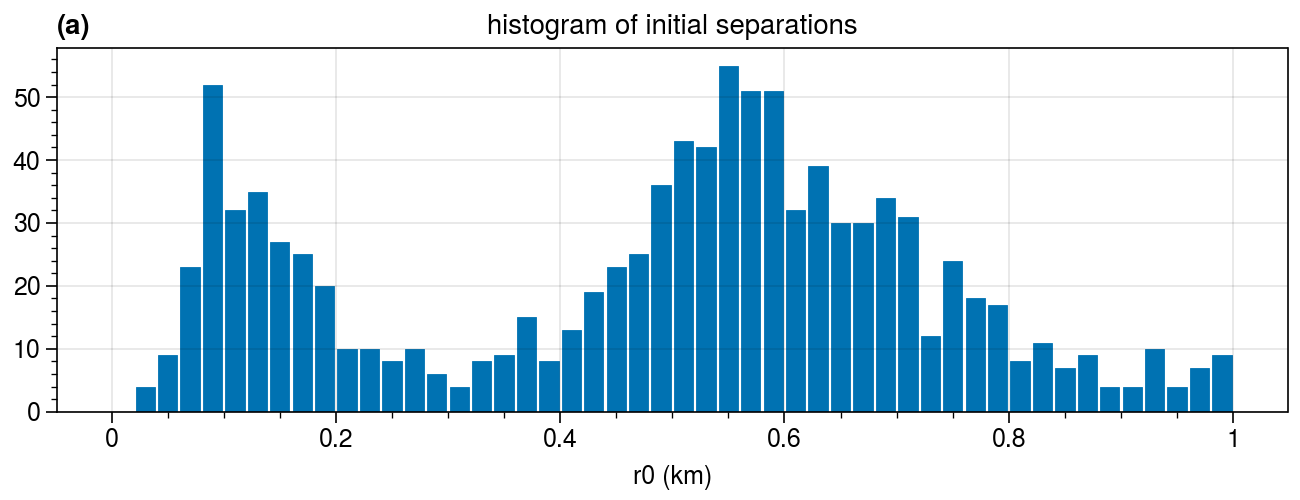

In [4]:
import proplot as pplt

fig, ax = pplt.subplots(figsize=(6.5,2.5), facecolor='w')
ax.hist(pairs.r0, bins=np.linspace(0, 1.0, 51), rwidth=0.86)
ax.set_xlabel('r0 (km)')
ax.format(abc='(a)', title='histogram of initial separations')

It is clear that there is a peak at about 0.1 km.  This is consistent with the fact that GLAD drifters are deployed with a targeted separation of 100m.

#### 2.3 Selecting original pairs

Based on the histogram plot, we select the original pairs with initial separation falling with 0.08~0.18 km.  This gives a set of 171 original pairs with $r_0=0.13$ km.

In [5]:
origin_pairs = rd.get_original_pairs(pairs, r0=[0.08, 0.18])

# This is equivalent to:
# condition = np.logical_and(pairs.r0>=0.08, pairs.r0<=0.18)
# origin_pairs = pairs.where(condition, drop=True).astype(pairs.dtypes)

origin_pairs

<xarray.Dataset>
Dimensions:   (pair: 171, particle: 2)
Coordinates:
  * pair      (pair) int32 5716 6266 6539 7083 7883 ... 43389 43396 43425 43463
  * particle  (particle) int32 0 1
Data variables:
    tlen      (pair) int32 3557 3142 3759 1999 3661 ... 2872 1314 4296 8039 3514
    stim      (pair) datetime64[ns] 2012-07-22T12:45:00 ... 2012-07-22T16:30:00
    r0        (pair) float32 0.08872 0.18 0.09602 ... 0.1259 0.09732 0.08311
    pID       (pair, particle) int32 20 21 22 23 23 24 ... 281 282 283 285 286
    xpos0     (pair, particle) float32 -88.2 -88.2 -88.2 ... -88.09 -88.08
    ypos0     (pair, particle) float32 28.8 28.8 28.8 28.8 ... 27.89 28.84 28.84
    idxI      (pair, particle) int32 121691 125248 134108 ... 1556133 1559647
    idxJ      (pair, particle) int32 130550 134107 137250 ... 1559647 1563161

Now we could plot the initial positions of original pairs

/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


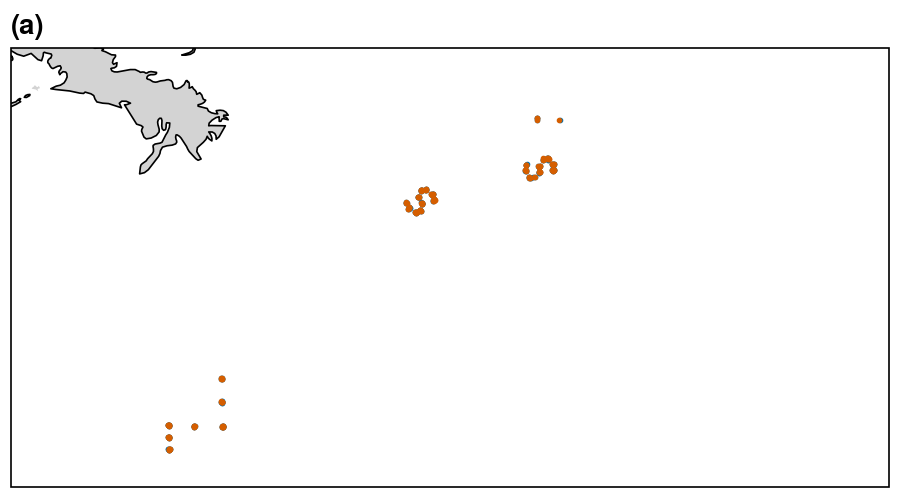

In [6]:
import proplot as pplt

fig, ax = pplt.subplots(figsize=(4.5,2.5), facecolor='w', proj='cyl')
ax.scatter(origin_pairs.xpos0, origin_pairs.ypos0, s=2)
ax.set_xlim([-90, -86])
ax.set_ylim([27.5, 29.5])
ax.format(abc='(a)', land=True, coast=True, reso='hi', landcolor='lightgray')

Now it is clear we find two 'S'-shaped pattern and a rotated 'Z'-shaped pattern of deployments

#### 2.4 Select chance pairs

In [7]:
chance_pairs = rd.get_chance_pairs(pairs, r0=[0.08, 0.18])
chance_pairs

<xarray.Dataset>
Dimensions:   (pair: 319, particle: 2)
Coordinates:
  * pair      (pair) int32 1946 1948 1955 3725 3798 ... 43164 43254 43312 43331
  * particle  (particle) int32 0 1
Data variables:
    tlen      (pair) int32 4921 6298 5949 2234 1275 ... 321 577 6244 439 4496
    stim      (pair) datetime64[ns] 2012-09-01T13:15:00 ... 2012-07-31T18:45:00
    r0        (pair) float32 0.1151 0.1689 0.08884 ... 0.08691 0.1514 0.1154
    pID       (pair, particle) int32 6 201 6 203 6 210 ... 289 275 282 276 282
    xpos0     (pair, particle) float32 -87.66 -87.66 -88.29 ... -89.34 -89.34
    ypos0     (pair, particle) float32 27.37 27.37 27.55 ... 26.45 27.95 27.95
    idxI      (pair, particle) int32 29251 34172 27874 ... 1515482 1519978
    idxJ      (pair, particle) int32 1095681 1100602 1110596 ... 1536563 1541059

Similarly, we plot the initial positions of chance pairs

/home/qianyk/miniconda3/envs/py310/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


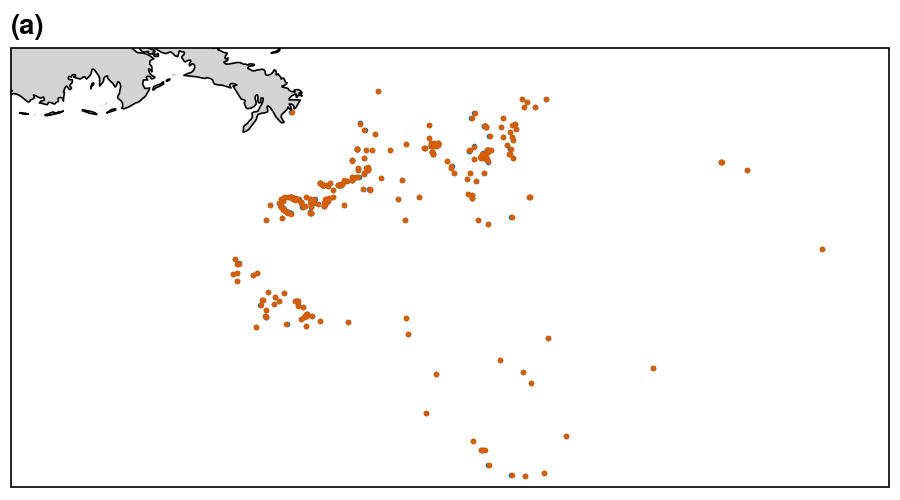

In [8]:
import proplot as pplt

fig, ax = pplt.subplots(figsize=(4.5,2.5), facecolor='w', proj='cyl')
ax.scatter(chance_pairs.xpos0, chance_pairs.ypos0, s=2)
ax.set_xlim([-91, -85])
ax.set_ylim([26.5, 29.5])
ax.format(abc='(a)', land=True, coast=True, reso='hi', landcolor='lightgray')

---

### 3. Conclusions

With the help of `xdispersion`, one can easily extract all the particle pairs from a drifter dataset.  In addition, taking statistics by histogram, selecting original/chance pairs, and plot initial locations of pairs are quite simple.
